# Machine Learning Pipeline - Diabetes

In [115]:
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [53]:
df = pd.read_csv('diabetes.csv')

In [54]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1) Exploratory Data Analysis

In [55]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

**Sumamrize data**

In [56]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627

**Catch numerical, categorical or cardinal variables**

In [57]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [58]:
cat_cols

['Outcome']

In [59]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [60]:
cat_but_car

[]

**Summarize categorical variables**

   Outcome      Ratio
0      500  65.104167
1      268  34.895833
##########################################


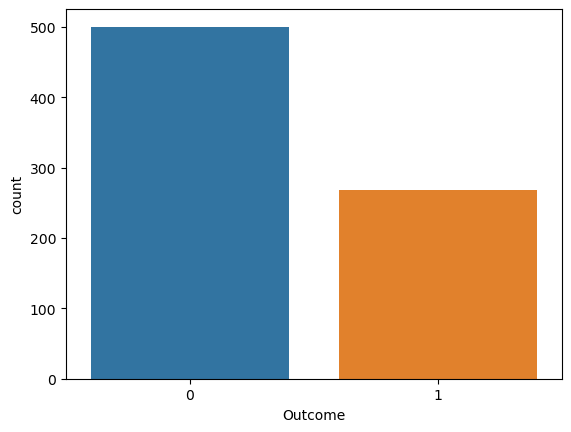

In [61]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

**Summarize numerical variables**

In [62]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


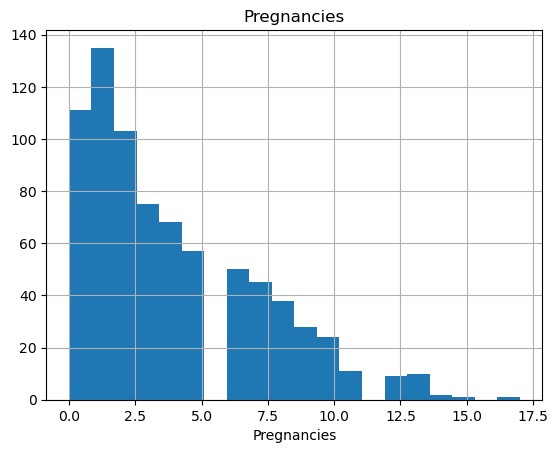

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


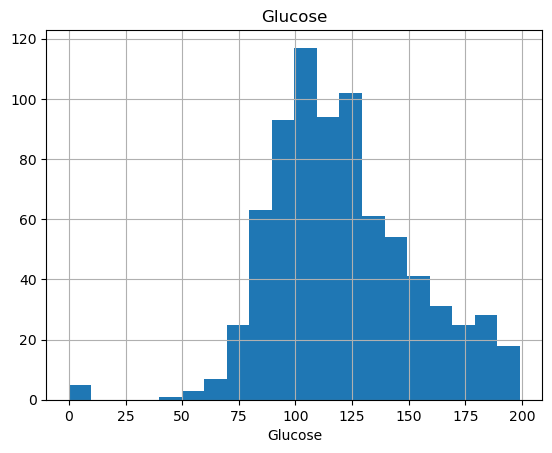

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


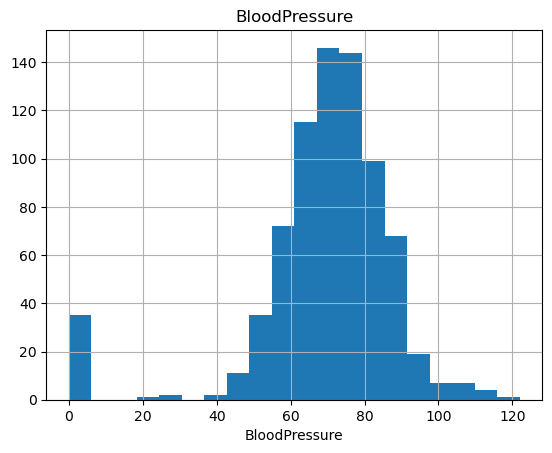

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


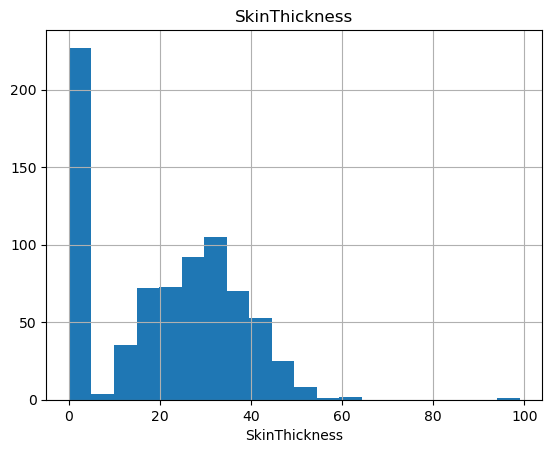

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


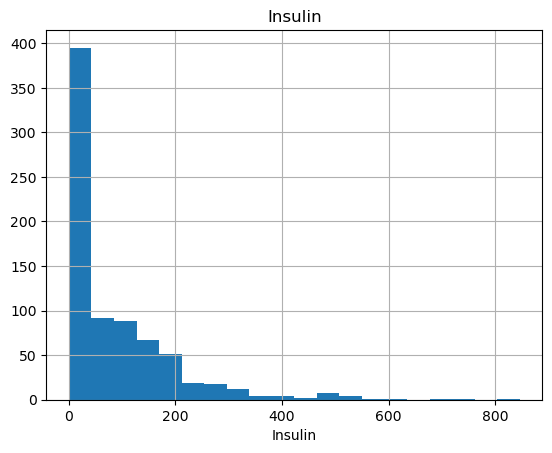

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


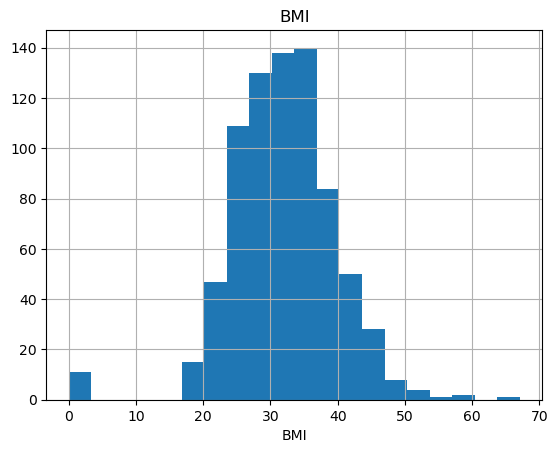

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


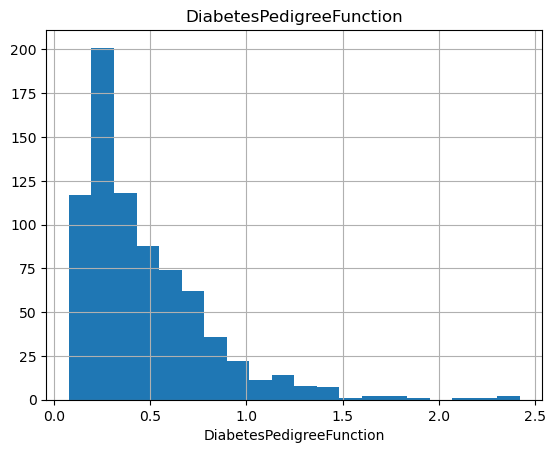

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


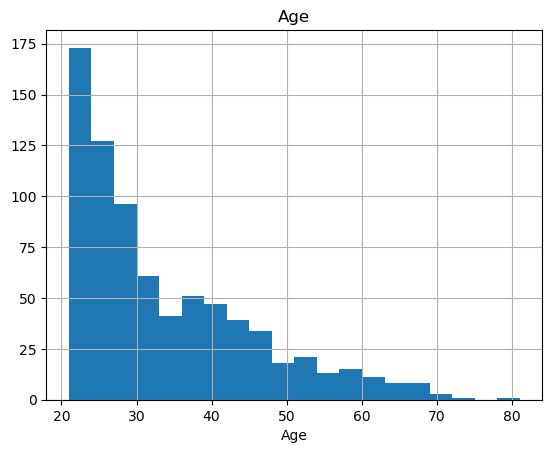

In [63]:
for col in num_cols:
    num_summary(df, col, plot=True)

**Corelation**

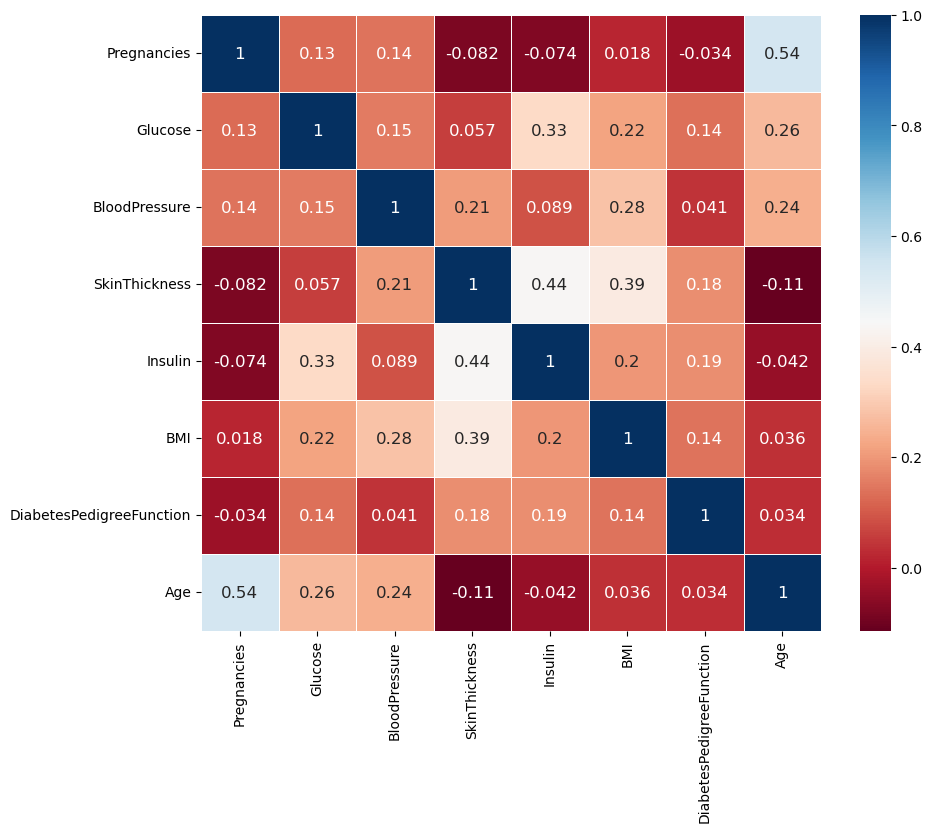

In [64]:
correlation_matrix(df, num_cols)

**Target variable analysis**

In [65]:
for col in num_cols:
    target_summary_with_num(df, 'Outcome', col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




## 2) Data Preprocessing and Future Engineering

In [66]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

**Upper variable names**

In [67]:
df.columns = [col.upper() for col in df.columns]

In [68]:
df

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


**New Features**

In [69]:
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

In [70]:
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healty", "overweight", "obese"])

In [71]:
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])

In [72]:
check_df(df)

##################### Shape #####################
(768, 12)
##################### Types #####################
PREGNANCIES                    int64
GLUCOSE                        int64
BLOODPRESSURE                  int64
SKINTHICKNESS                  int64
INSULIN                        int64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_AGE_CAT                   object
NEW_BMI_RANGE               category
NEW_BLOODPRESSURE           category
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137

In [73]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

Observations: 768
Variables: 12
cat_cols: 4
num_cols: 8
cat_but_car: 0
num_but_cat: 3


In [74]:
cat_cols

['NEW_AGE_CAT', 'OUTCOME', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE']

In [75]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

In [76]:
for col in cat_cols:
    cat_summary(df, col)

           NEW_AGE_CAT      Ratio
young              488  63.541667
middleage          230  29.947917
old                 50   6.510417
##########################################
   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
##########################################
             NEW_BMI_RANGE      Ratio
obese                  472  61.458333
overweight             179  23.307292
healty                 102  13.281250
underweight             15   1.953125
##########################################
        NEW_BLOODPRESSURE      Ratio
normal                563  73.307292
hs1                   145  18.880208
hs2                    60   7.812500
##########################################


In [77]:
for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




In [78]:
cat_cols = [col for col in cat_cols if 'OUTCOME' not in col]

**Encoding**

In [81]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [82]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT_old,NEW_AGE_CAT_young,NEW_BMI_RANGE_healty,NEW_BMI_RANGE_overweight,NEW_BMI_RANGE_obese,NEW_BLOODPRESSURE_hs1,NEW_BLOODPRESSURE_hs2
0,6,148,72,35,0,33.6,0.627,50,1,0,0,0,0,1,0,0
1,1,85,66,29,0,26.6,0.351,31,0,0,1,0,1,0,0,0
2,8,183,64,0,0,23.3,0.672,32,1,0,1,1,0,0,0,0
3,1,89,66,23,94,28.1,0.167,21,0,0,1,0,1,0,0,0
4,0,137,40,35,168,43.1,2.288,33,1,0,1,0,0,1,0,0


In [83]:
df.columns = [col.upper() for col in df.columns]

In [84]:
df.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN',
       'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'OUTCOME', 'NEW_AGE_CAT_OLD',
       'NEW_AGE_CAT_YOUNG', 'NEW_BMI_RANGE_HEALTY', 'NEW_BMI_RANGE_OVERWEIGHT',
       'NEW_BMI_RANGE_OBESE', 'NEW_BLOODPRESSURE_HS1',
       'NEW_BLOODPRESSURE_HS2'],
      dtype='object')

In [85]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

Observations: 768
Variables: 16
cat_cols: 8
num_cols: 8
cat_but_car: 0
num_but_cat: 8


In [86]:
cat_cols = [col for col in cat_cols if 'OUTCOME' not in col]

In [87]:
cat_cols

['NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_BMI_RANGE_HEALTY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2']

In [88]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

**Outlier Analysis**

In [92]:
for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [93]:
replace_with_thresholds(df, 'INSULIN')

In [94]:
for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


**Scaling**

In [97]:
X_scaled = StandardScaler().fit_transform(df[num_cols])

In [99]:
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [105]:
X = df.drop('OUTCOME', axis=1)
y = df['OUTCOME']

In [106]:
check_df(df)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                 float64
GLUCOSE                     float64
BLOODPRESSURE               float64
SKINTHICKNESS               float64
INSULIN                     float64
BMI                         float64
DIABETESPEDIGREEFUNCTION    float64
AGE                         float64
OUTCOME                       int64
NEW_AGE_CAT_OLD               uint8
NEW_AGE_CAT_YOUNG             uint8
NEW_BMI_RANGE_HEALTY          uint8
NEW_BMI_RANGE_OVERWEIGHT      uint8
NEW_BMI_RANGE_OBESE           uint8
NEW_BLOODPRESSURE_HS1         uint8
NEW_BLOODPRESSURE_HS2         uint8
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  \
0     0.639947  0.848324       0.149641       0.907270 -0.787602  0.204013   
1    -0.844885 -1.123396      -0.160546       0.530902 -0.787602 -0.684422   
2     1.233880  1

**Functionalize all data steps**

In [107]:
def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

In [109]:
df = pd.read_csv("diabetes.csv")

In [110]:
X, y = diabetes_data_prep(df)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4
Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9


## 3) Base Model

In [112]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [116]:
base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7604 (LR) 
accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.6888 (CART) 
accuracy: 0.776 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.7487 (GBM) 
accuracy: 0.7448 (XGBoost) 
accuracy: 0.7383 (LightGBM) 


In [117]:
base_models(X, y, scoring="roc_auc")

Base Models....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.6538 (CART) 
roc_auc: 0.8228 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8244 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 


In [118]:
base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7604 (LR) 
accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.681 (CART) 
accuracy: 0.7812 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.7526 (GBM) 
accuracy: 0.7448 (XGBoost) 
accuracy: 0.7383 (LightGBM) 


## 4) Automated Hyperparameter Optimization

In [119]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

In [120]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [121]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [122]:
best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6558
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8243
roc_auc (After): 0.8351
RF best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 15, 'n_estimators': 300}

########## XGBoost ##########
roc_auc (Before): 0.8015
roc_auc (After): 0.8179
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8185
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



## 5) Stacking & Ensemble Learning

In [123]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [124]:
voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.7708333333333334
F1Score: 0.6382429932224188
ROC_AUC: 0.8352484928312832


## 6) Prediction for a New Observation

In [130]:
random_user = X.sample(1, random_state=50)
random_user

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
575,-0.844885,-0.059293,-1.297896,1.660007,-0.113914,0.445159,-0.579489,-0.701198,0,1,0,0,0,1,0,0


In [136]:
df[df.index == random_user.index.values[0]]

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE,NEW_BLOODPRESSURE
575,1,119,44,47,63,35.5,0.28,25,0,normal,young,obese,normal


In [138]:
voting_clf.predict(random_user)

array([0], dtype=int64)

**Save model**

In [140]:
joblib.dump(voting_clf, 'voting_clf.pkl')

['voting_clf.pkl']

**Load saved model as new model**

In [141]:
new_model = joblib.load('voting_clf.pkl')

In [142]:
new_model.predict(random_user)

array([0], dtype=int64)